In [1]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset (assumes file is already uploaded to Google Colab)
file_path = '/content/Model 3_Region_Income Group.xlsx'  # Update the path if different
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Prepare data for panel data regression
# Combining "Region_Income Group" and "Country Name" for the entity index
data['Entity'] = data['Region_Income Group'] + "_" + data['Country Name']

# Drop unnecessary columns for panel regression (like categorical variables not encoded)
data_clean = data.drop(columns=['Region_Income Group', 'Country Name'], errors='ignore')

# Set the panel data structure
data_clean = data_clean.set_index(['Entity', 'Year'])

# Multicollinearity check (VIF)
# Selecting numerical columns (excluding the target variable)
X = data_clean.drop(columns=['Producer price inflation, annual'], errors='ignore')

# Drop columns with any missing values for VIF calculation
X = X.dropna(axis=1)

# Add a constant for the VIF calculation
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Save the prepared dataset for panel regression to a CSV file (optional)
prepared_file_path = '/content/prepared_panel_data.csv'
data_clean.reset_index().to_csv(prepared_file_path, index=False)
print(f"Prepared dataset saved to: {prepared_file_path}")


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
                                        Feature           VIF
0                                         const  0.000000e+00
1               East Asia & Pacific_High income  2.440680e+03
2       East Asia & Pacific_Lower middle income  1.654926e+04
3       East Asia & Pacific_Upper middle income  8.162203e+02
4             Europe & Central Asia_High income  3.970620e+04
..                                          ...           ...
98                 Population growth (annual %)  1.073375e+01
99                           Population, female           inf
100  Population, female (% of total population)  3.298593e+08
101                            Population, male           inf
102    Population, male (% of total population)  6.260028e+08

[103 rows x 2 columns]
Prepared dataset saved to: /content/prepared_panel_data.csv


In [2]:
# Step 1: Calculate correlation matrix
correlation_matrix = X.corr()

# Step 2: Identify highly correlated variables
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns
                   for col2 in correlation_matrix.columns
                   if (col1 != col2) and (correlation_matrix.loc[col1, col2] > 0.9)]

# Print pairs of highly correlated variables
print("Highly correlated variable pairs (correlation > 0.9):")
print(high_corr_pairs)

# Step 3: Drop one variable from each pair of highly correlated variables
variables_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
X_reduced = X.drop(columns=variables_to_drop)

# Step 4: Recalculate VIF for reduced dataset
vif_data_reduced = pd.DataFrame()
vif_data_reduced['Feature'] = X_reduced.columns
vif_data_reduced['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print("Reduced Variance Inflation Factor (VIF):")
print(vif_data_reduced)


Highly correlated variable pairs (correlation > 0.9):
[('Trade (% of GDP)', 'Exports of goods and services (% of GDP)'), ('Trade (% of GDP)', 'Imports of goods and services (% of GDP)'), ('Exports of goods and services (% of GDP)', 'Trade (% of GDP)'), ('Exports of goods and services (current US$)', 'Imports of goods and services (current US$)'), ('Exports of goods and services (current US$)', 'Merchandise exports (current US$)'), ('Exports of goods and services (current US$)', 'Merchandise imports (current US$)'), ('Exports of goods and services (current US$)', 'Service imports (BoP, current US$)'), ('Imports of goods and services (% of GDP)', 'Trade (% of GDP)'), ('Imports of goods and services (current US$)', 'Exports of goods and services (current US$)'), ('Imports of goods and services (current US$)', 'Merchandise exports (current US$)'), ('Imports of goods and services (current US$)', 'Merchandise imports (current US$)'), ('Imports of goods and services (current US$)', 'Service e

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Reduced Variance Inflation Factor (VIF):
                                       Feature           VIF
0                                        const  0.000000e+00
1              East Asia & Pacific_High income  1.801440e+15
2      East Asia & Pacific_Lower middle income  1.580210e+14
3      East Asia & Pacific_Upper middle income  3.002400e+15
4            Europe & Central Asia_High income           inf
..                                         ...           ...
56             Human Development Index (value)  1.294909e+01
57             Income share held by lowest 10%  2.273964e+00
58                Population growth (annual %)  2.102592e+00
59  Population, female (% of total population)  1.534708e+12
60    Population, male (% of total population)  1.120452e+11

[61 rows x 2 columns]


In [3]:
# Manually drop variables with very high VIF or inf values
high_vif_threshold = 10
variables_to_keep = vif_data_reduced[vif_data_reduced['VIF'] < high_vif_threshold]['Feature']
X_final = X_reduced[variables_to_keep]

# Recalculate VIF after further pruning
vif_data_final = pd.DataFrame()
vif_data_final['Feature'] = X_final.columns
vif_data_final['VIF'] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

print("Final Variance Inflation Factor (VIF):")
print(vif_data_final)


Final Variance Inflation Factor (VIF):
                                              Feature         VIF
0                                               const  355.699566
1              Consumer price index (CPI, 2010 = 100)    1.805400
2               Inflation, consumer prices (annual %)    7.738274
3                      Energy price inflation, annual    3.290880
4                        Food price inflation, annual    5.210201
5                  Inflation, GDP deflator (annual %)    3.147728
6           Central government debt, total (% of GDP)    1.490306
7                              Broad money (% of GDP)    1.932234
8                           Lending interest rate (%)    5.427165
9   Interest rate spread (lending rate minus depos...    4.173932
10  Risk premium on lending (lending rate minus tr...    2.216583
11                             Real interest rate (%)    2.124226
12    Real effective exchange rate index (2010 = 100)    1.132621
13    Exports of goods and services (

In [7]:
!pip install linearmodels

from linearmodels.panel import PanelOLS

# Ensure the target variable and independent variables are in the dataset
# Exclude 'const' as it was added for VIF calculation
variables_to_keep = [var for var in variables_to_keep if var != 'const']
prepared_data = data_clean[["Producer price inflation, annual"] + list(variables_to_keep)]

# Drop missing values (if any)
prepared_data = prepared_data.dropna()

# Define the dependent and independent variables
y = prepared_data["Producer price inflation, annual"]
X = prepared_data.drop(columns=["Producer price inflation, annual"])

# Add a constant term for the FE model
X = sm.add_constant(X)

# Fit the Fixed Effects model
model = PanelOLS(y, X, entity_effects=True)  # entity_effects=True for Fixed Effects
results = model.fit()

# Display the summary of results
print(results.summary)



                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Producer price inflation, annual   R-squared:                        0.7536
Estimator:                                 PanelOLS   R-squared (Between):              0.4675
No. Observations:                              2805   R-squared (Within):               0.7536
Date:                              Thu, Jan 16 2025   R-squared (Overall):              0.6983
Time:                                      17:03:36   Log-likelihood                   -8789.8
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      239.57
Entities:                                       187   P-value                           0.0000
Avg Obs:                                     15.000   Distribution:                 F(33,2585)
Min Obs:                                     15.00

In [8]:
from linearmodels.panel import RandomEffects

# Prepare the data for the Random Effects model
# Ensure the target variable and independent variables are in the dataset
prepared_data = data_clean[["Producer price inflation, annual"] + list(variables_to_keep)]

# Drop missing values (if any)
prepared_data = prepared_data.dropna()

# Define the dependent and independent variables
y = prepared_data["Producer price inflation, annual"]
X = prepared_data.drop(columns=["Producer price inflation, annual"])

# Add a constant term for the RE model
X = sm.add_constant(X)

# Fit the Random Effects model
model = RandomEffects(y, X)
results = model.fit()

# Display the summary of results
print(results.summary)


                               RandomEffects Estimation Summary                               
Dep. Variable:     Producer price inflation, annual   R-squared:                        0.7561
Estimator:                            RandomEffects   R-squared (Between):              0.8233
No. Observations:                              2805   R-squared (Within):               0.7474
Date:                              Thu, Jan 16 2025   R-squared (Overall):              0.7621
Time:                                      17:05:45   Log-likelihood                   -8946.2
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      260.25
Entities:                                       187   P-value                           0.0000
Avg Obs:                                     15.000   Distribution:                 F(33,2771)
Min Obs:                                     15.00

In [13]:
import numpy as np
from scipy.stats import chi2

# Fit the Fixed Effects model
fe_model = PanelOLS(y, X, entity_effects=True).fit()

# Fit the Random Effects model
re_model = RandomEffects(y, X).fit()

# Extract coefficients
beta_fe = fe_model.params
beta_re = re_model.params

# Extract covariance matrices
cov_fe = fe_model.cov
cov_re = re_model.cov

# Calculate the difference in coefficients
beta_diff = beta_fe - beta_re

# Calculate the test statistic (Hausman statistic)
cov_diff = cov_fe - cov_re
hausman_stat = beta_diff.T @ np.linalg.inv(cov_diff) @ beta_diff

# Degrees of freedom
df = len(beta_diff)

# Calculate the p-value
hausman_p_value = 1 - chi2.cdf(hausman_stat, df)

# Print results
print(f"Hausman Test Statistic: {hausman_stat:.4f}")
print(f"p-value: {hausman_p_value:.4f}")

# Decision
if hausman_p_value < 0.05:
    print("Reject the null hypothesis: Fixed Effects (FE) model is more appropriate.")
else:
    print("Fail to reject the null hypothesis: Random Effects (RE) model is more appropriate.")


Hausman Test Statistic: 110.7550
p-value: 0.0000
Reject the null hypothesis: Fixed Effects (FE) model is more appropriate.


In [21]:
# Display the Fixed Effects model summary
print(fe_model.summary)

# Extract significant coefficients (p-value < 0.05)
significant_coefficients = fe_model.params[fe_model.pvalues < 0.05]
significant_pvalues = fe_model.pvalues[fe_model.pvalues < 0.05]

# Calculate impact in percentage (scaled to 100%)
percent_impact = significant_coefficients * 100

# Combine into a DataFrame
fe_insights = pd.DataFrame({
    'Coefficient': significant_coefficients,
    'P-Value': significant_pvalues,
    'Impact (%)': percent_impact,
    'Impact Direction': ['Positive' if coef > 0 else 'Negative' for coef in significant_coefficients]
}).sort_values(by='Coefficient', ascending=False)

print("Significant Variables and Their Coefficients (with Impact in %):")
print(fe_insights)

# Save the insights to a CSV file
fe_insights.to_csv('/content/FE_Model_Insights_Percentage.csv', index=True)
print("Insights saved to /content/FE_Model_Insights_Percentage.csv")


                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Producer price inflation, annual   R-squared:                        0.7536
Estimator:                                 PanelOLS   R-squared (Between):              0.4675
No. Observations:                              2805   R-squared (Within):               0.7536
Date:                              Thu, Jan 16 2025   R-squared (Overall):              0.6983
Time:                                      17:10:22   Log-likelihood                   -8789.8
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      239.57
Entities:                                       187   P-value                           0.0000
Avg Obs:                                     15.000   Distribution:                 F(33,2585)
Min Obs:                                     15.00

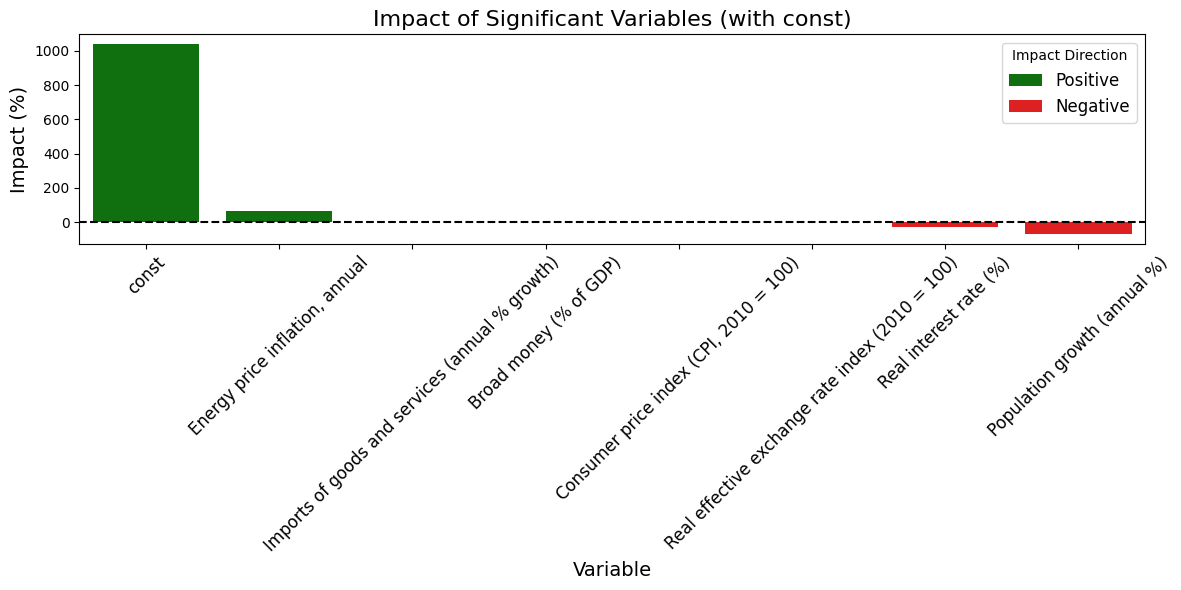

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Significant Variables with 'const'
plt.figure(figsize=(12, 6))
sns.barplot(data=fe_insights.reset_index(), x='index', y='Impact (%)', hue='Impact Direction', dodge=False, palette={'Positive': 'green', 'Negative': 'red'})
plt.title('Impact of Significant Variables (with const)', fontsize=16)
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Impact (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Impact Direction', fontsize=12)
plt.tight_layout()
plt.show()


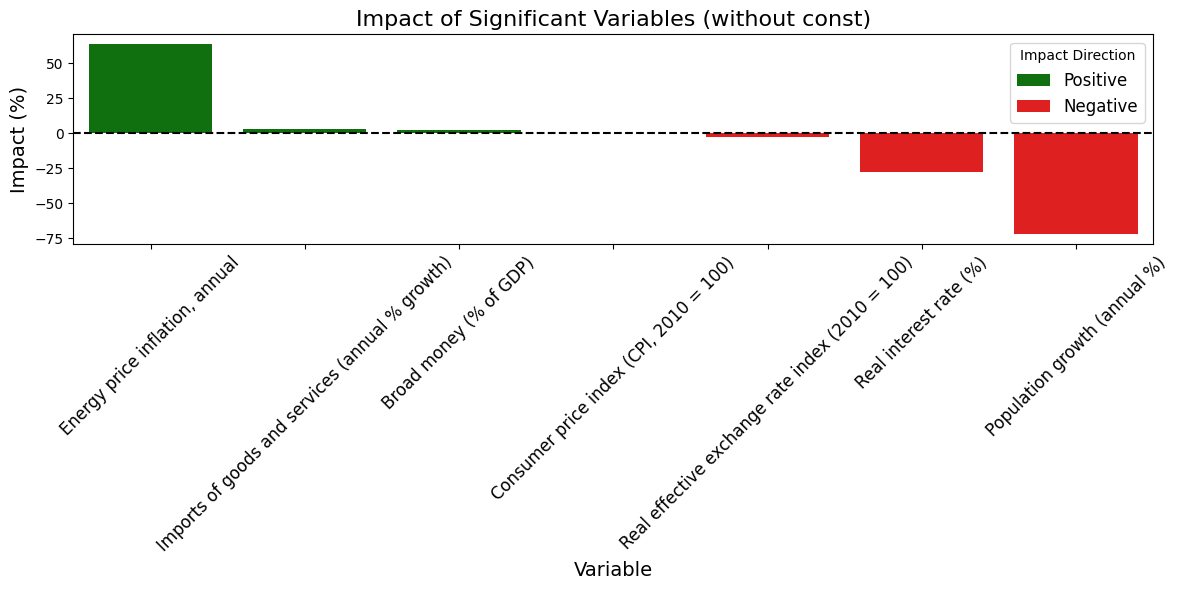

In [23]:
# Exclude 'const' from the dataset
fe_insights_without_const = fe_insights[fe_insights.index != 'const']

# Visualization: Significant Variables without 'const'
plt.figure(figsize=(12, 6))
sns.barplot(data=fe_insights_without_const.reset_index(), x='index', y='Impact (%)', hue='Impact Direction', dodge=False, palette={'Positive': 'green', 'Negative': 'red'})
plt.title('Impact of Significant Variables (without const)', fontsize=16)
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Impact (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Impact Direction', fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-28-031ed376192f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=extreme_entities.index, y=extreme_entities.values, palette='viridis')


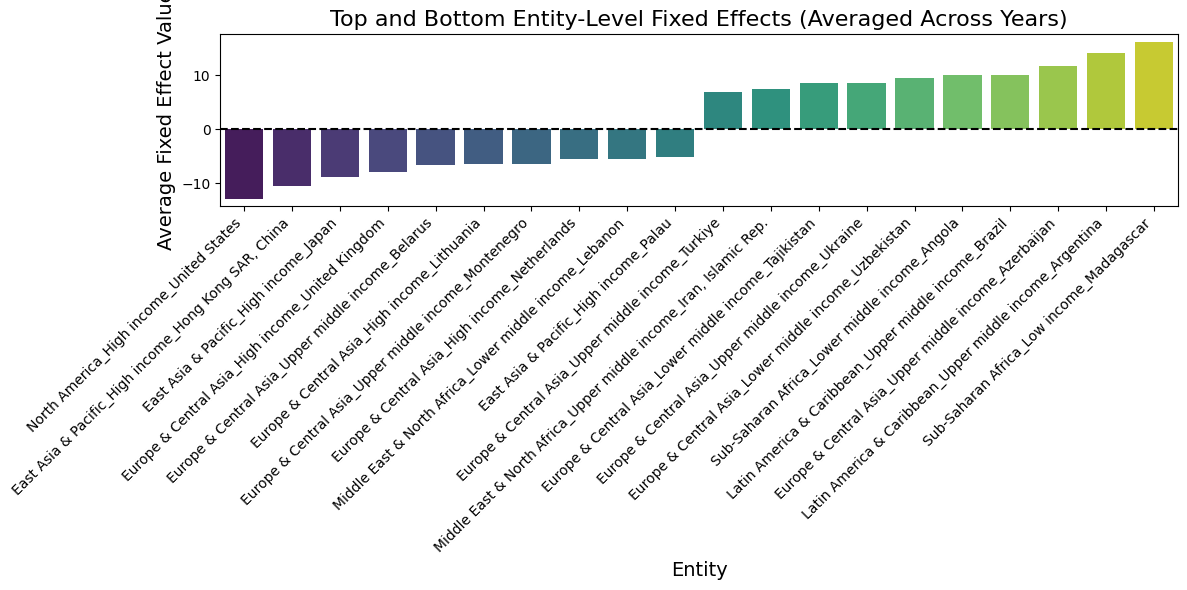

In [28]:
# Aggregate entity effects by taking the mean over all years
entity_effects_mean = entity_effects.mean(axis=1).sort_values()

# Display top 10 and bottom 10 entities
top_entities = entity_effects_mean.head(10)
bottom_entities = entity_effects_mean.tail(10)

# Combine top and bottom entities
extreme_entities = pd.concat([top_entities, bottom_entities])

# Visualization: Bar plot for top and bottom entities
plt.figure(figsize=(12, 6))
sns.barplot(x=extreme_entities.index, y=extreme_entities.values, palette='viridis')
plt.title('Top and Bottom Entity-Level Fixed Effects (Averaged Across Years)', fontsize=16)
plt.xlabel('Entity', fontsize=14)
plt.ylabel('Average Fixed Effect Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


<ipython-input-29-15a83ce6bd51>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region_effects = entity_effects_mean.groupby(entity_effects_mean.index).mean().sort_values()
<ipython-input-29-15a83ce6bd51>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_effects.index, y=region_effects.values, palette='coolwarm')


Region-Level Fixed Effects (Averaged Across Entities and Years):
0
North America                -6.723016
East Asia & Pacific          -1.882680
Europe & Central Asia        -1.445508
Middle East & North Africa    0.436163
South Asia                    0.784582
Latin America & Caribbean     0.833845
Sub-Saharan Africa            2.208584
dtype: float64


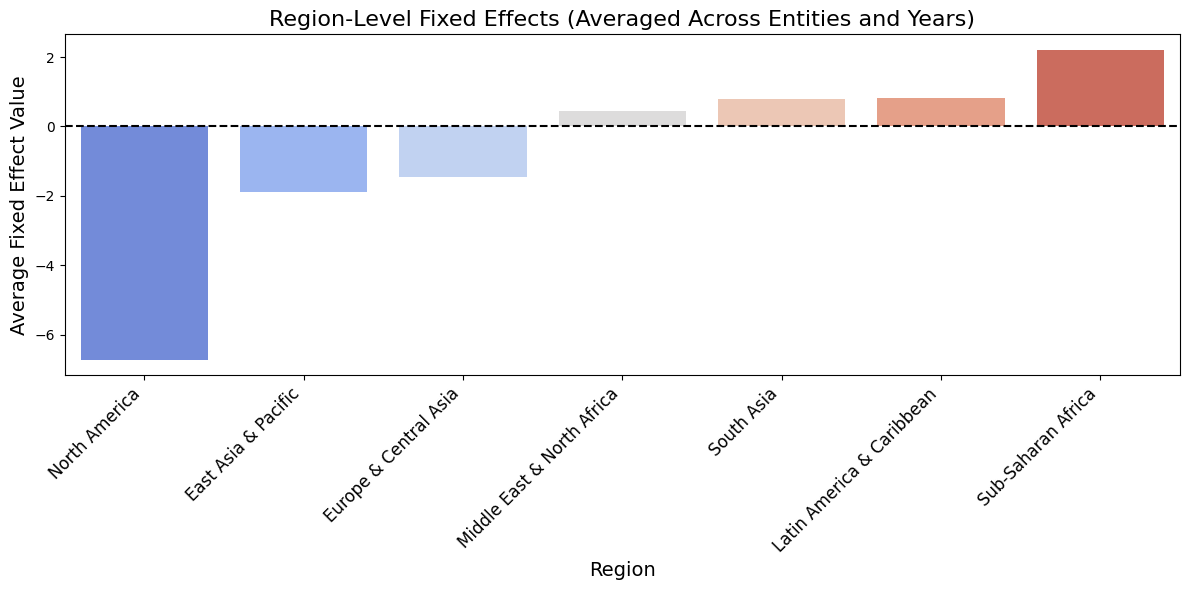

In [29]:
# Extract region names from the 'Entity' index
# Assuming the region name is the first part of the entity before an underscore
entity_effects_mean.index = entity_effects_mean.index.str.extract(r'(^.+?)_')[0]

# Aggregate fixed effects by region
region_effects = entity_effects_mean.groupby(entity_effects_mean.index).mean().sort_values()

# Display region-level insights
print("Region-Level Fixed Effects (Averaged Across Entities and Years):")
print(region_effects)

# Plot region-level effects
plt.figure(figsize=(12, 6))
sns.barplot(x=region_effects.index, y=region_effects.values, palette='coolwarm')
plt.title('Region-Level Fixed Effects (Averaged Across Entities and Years)', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Average Fixed Effect Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


Yearly Fixed Effects for Regions (Preview):
   Year                      Region  Producer price inflation, annual
0  2009         East Asia & Pacific                          1.215345
1  2009       Europe & Central Asia                         -2.164867
2  2009   Latin America & Caribbean                          0.585439
3  2009  Middle East & North Africa                         -2.808889
4  2009               North America                         -1.697199


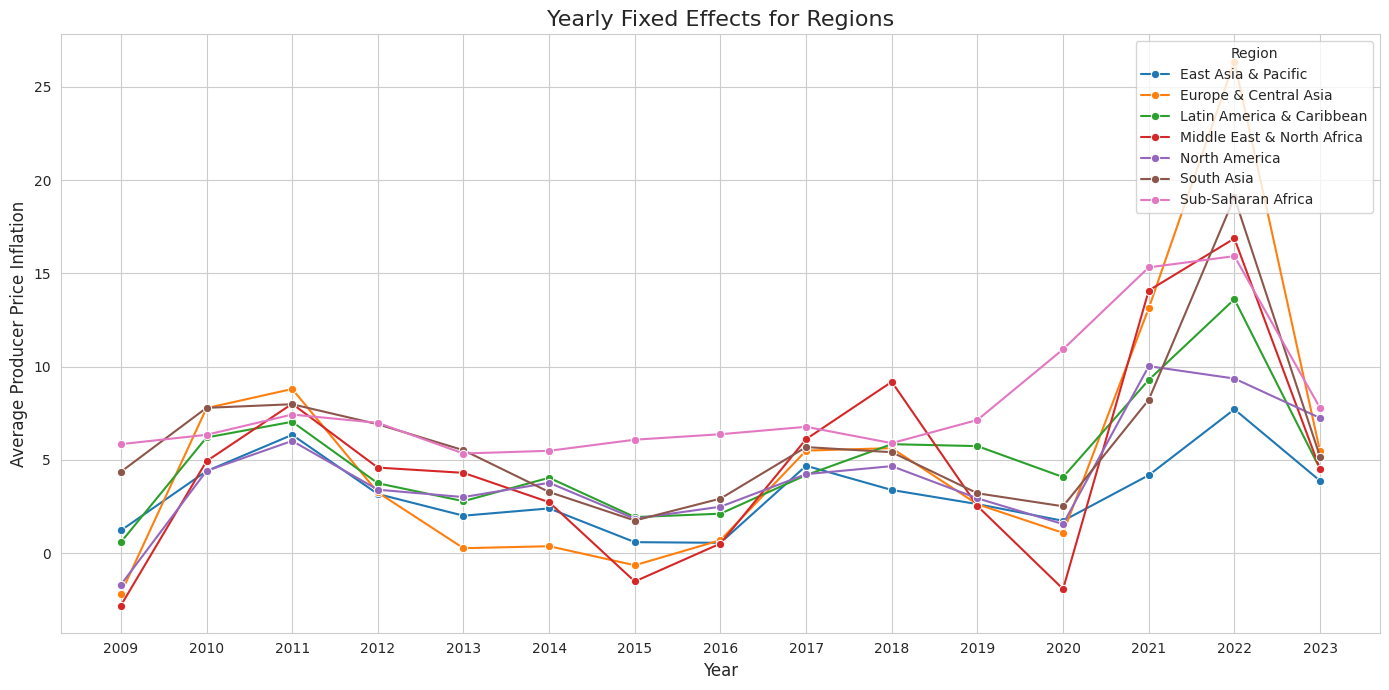

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract the Region from the Entity column
# Assuming the 'Entity' column is structured as "Region_Income_Country"
data_clean_reset['Region'] = data_clean_reset['Entity'].str.extract(r'^(.*?)_')

# Step 2: Calculate mean fixed effects for each Region and Year
yearly_region_effects = (
    data_clean_reset.groupby(['Year', 'Region'])
    .mean(numeric_only=True)['Producer price inflation, annual']
    .reset_index()
)

# Step 3: Display yearly fixed effects for regions (preview)
print("Yearly Fixed Effects for Regions (Preview):")
print(yearly_region_effects.head())

# Step 4: Visualization for Yearly Insights Across Regions
plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')

# Lineplot for yearly fixed effects by region
sns.lineplot(
    data=yearly_region_effects,
    x='Year',
    y='Producer price inflation, annual',
    hue='Region',
    marker='o'
)

# Customize the plot
plt.title('Yearly Fixed Effects for Regions', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Producer Price Inflation', fontsize=12)
plt.legend(title='Region', fontsize=10, loc='upper right')

# Ensure all years are displayed on the x-axis
plt.xticks(
    ticks=sorted(yearly_region_effects['Year'].unique()),  # Sorted unique years
    labels=sorted(yearly_region_effects['Year'].unique()),  # Display all years
    fontsize=10
)

plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [43]:
# Extract the income group from the Entity column
data_clean_reset['Income Group'] = data_clean_reset['Entity'].str.extract(r'_(High income|Upper middle income|Lower middle income|Low income)')

# Display unique income groups
print("Unique Income Groups Extracted:")
print(data_clean_reset['Income Group'].unique())


Unique Income Groups Extracted:
['Low income' 'Upper middle income' 'Lower middle income' 'High income']


In [45]:
# Calculate mean fixed effects for each Income Group
income_group_effects = (
    data_clean_reset.groupby('Income Group')
    .mean(numeric_only=True)  # Ensure only numeric columns are considered
    .sort_values(by='Producer price inflation, annual', ascending=False)['Producer price inflation, annual']
)

# Display the fixed effects
print("Income Group-Level Fixed Effects (Averaged Across Years):")
print(income_group_effects)


Income Group-Level Fixed Effects (Averaged Across Years):
Income Group
Low income             8.907287
Lower middle income    6.361805
Upper middle income    5.684340
High income            3.518095
Name: Producer price inflation, annual, dtype: float64


<ipython-input-46-0746752784b6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


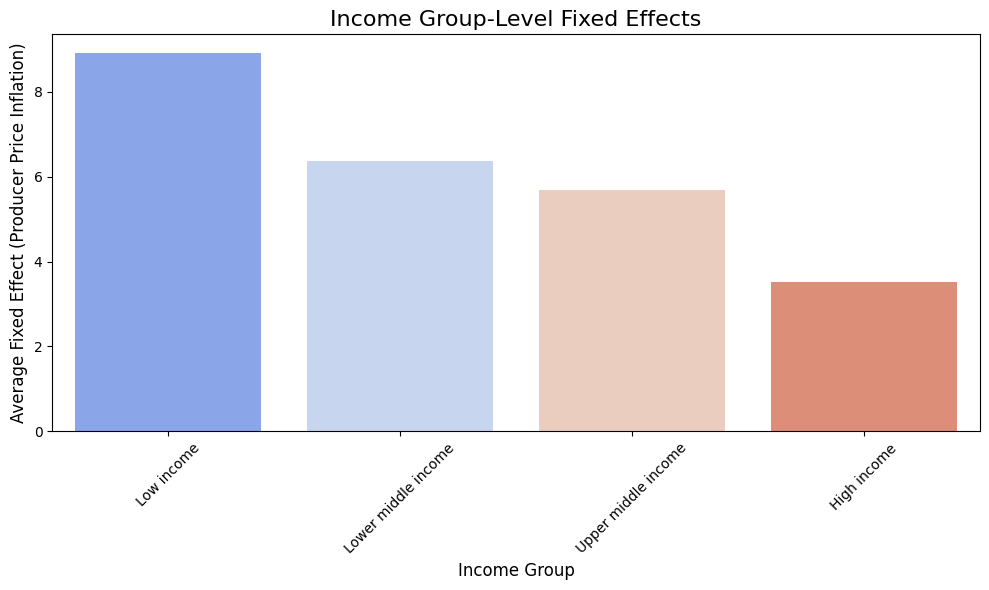

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Income Group' effects were calculated in the previous step
plt.figure(figsize=(10, 6))
sns.barplot(
    x=income_group_effects.index,
    y=income_group_effects.values,
    palette='coolwarm'
)
plt.title('Income Group-Level Fixed Effects', fontsize=16)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Average Fixed Effect (Producer Price Inflation)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


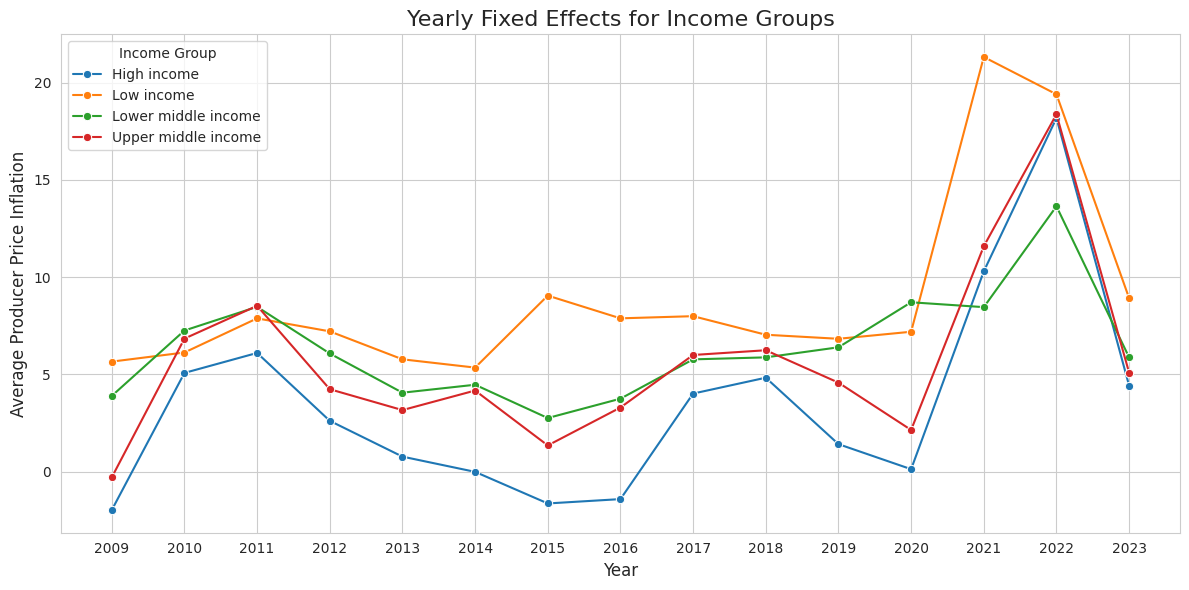

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Create a line plot for yearly fixed effects across income groups
sns.lineplot(
    data=yearly_income_group_effects,
    x='Year',
    y='Producer price inflation, annual',
    hue='Income Group',
    marker='o'
)

# Customize the plot
plt.title('Yearly Fixed Effects for Income Groups', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Producer Price Inflation', fontsize=12)
plt.legend(title='Income Group', fontsize=10)

# Ensure all years are shown on the x-axis
plt.xticks(
    ticks=yearly_income_group_effects['Year'].unique(),  # Unique years from the dataset
    labels=yearly_income_group_effects['Year'].unique(),  # Show all years
    fontsize=10
)

plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


Top 10 Countries with Positive Fixed Effects:
Country
Madagascar            16.110493
Argentina             14.091698
Azerbaijan            11.613857
Brazil                10.073345
Angola                 9.956895
Uzbekistan             9.522584
Ukraine                8.539399
Tajikistan             8.482780
Iran, Islamic Rep.     7.343479
Turkiye                6.923312
Name: Fixed Effect, dtype: float64


<ipython-input-69-b1a549a5c5b3>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


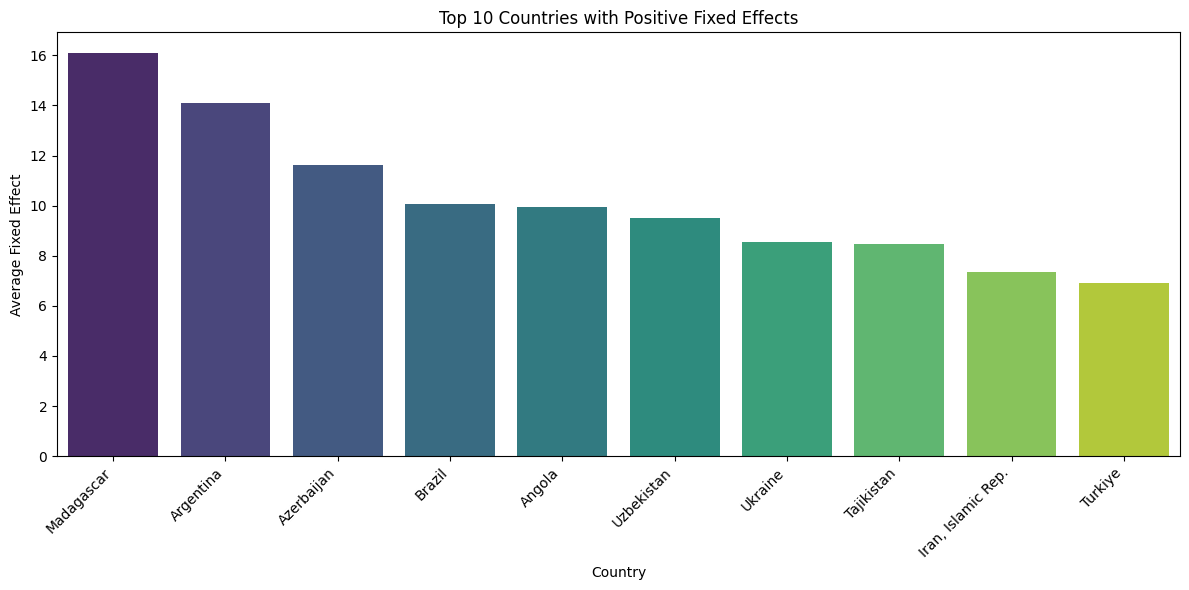

In [69]:
# Step 1: Reshape the MultiIndex DataFrame to collapse MultiIndex columns
# Flatten the MultiIndex columns for easier handling
entity_effects_reset.columns = ['_'.join([str(level) for level in col]).strip('_') for col in entity_effects_reset.columns]

# Step 2: Identify and select the relevant columns
# Columns related to estimated effects and Country
effect_cols = [col for col in entity_effects_reset.columns if 'estimated_effects' in col]
country_effects_df = entity_effects_reset[['Country'] + effect_cols]

# Step 3: Melt the DataFrame into a long format
country_effects_melted = country_effects_df.melt(
    id_vars='Country',
    value_vars=effect_cols,
    var_name='Year',
    value_name='Fixed Effect'
)

# Step 4: Group by Country and calculate the mean fixed effect
country_effects_mean = country_effects_melted.groupby('Country')['Fixed Effect'].mean()

# Step 5: Sort the results in descending order
sorted_country_effects = country_effects_mean.sort_values(ascending=False)

# Step 6: Extract the top 10 countries with positive fixed effects
top_10_countries_positive = sorted_country_effects.head(10)
print("Top 10 Countries with Positive Fixed Effects:")
print(top_10_countries_positive)

# Step 7: Visualization for Colab
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_countries_positive.index,
    y=top_10_countries_positive.values,
    palette='viridis'
)
plt.title('Top 10 Countries with Positive Fixed Effects')
plt.xlabel('Country')
plt.ylabel('Average Fixed Effect')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


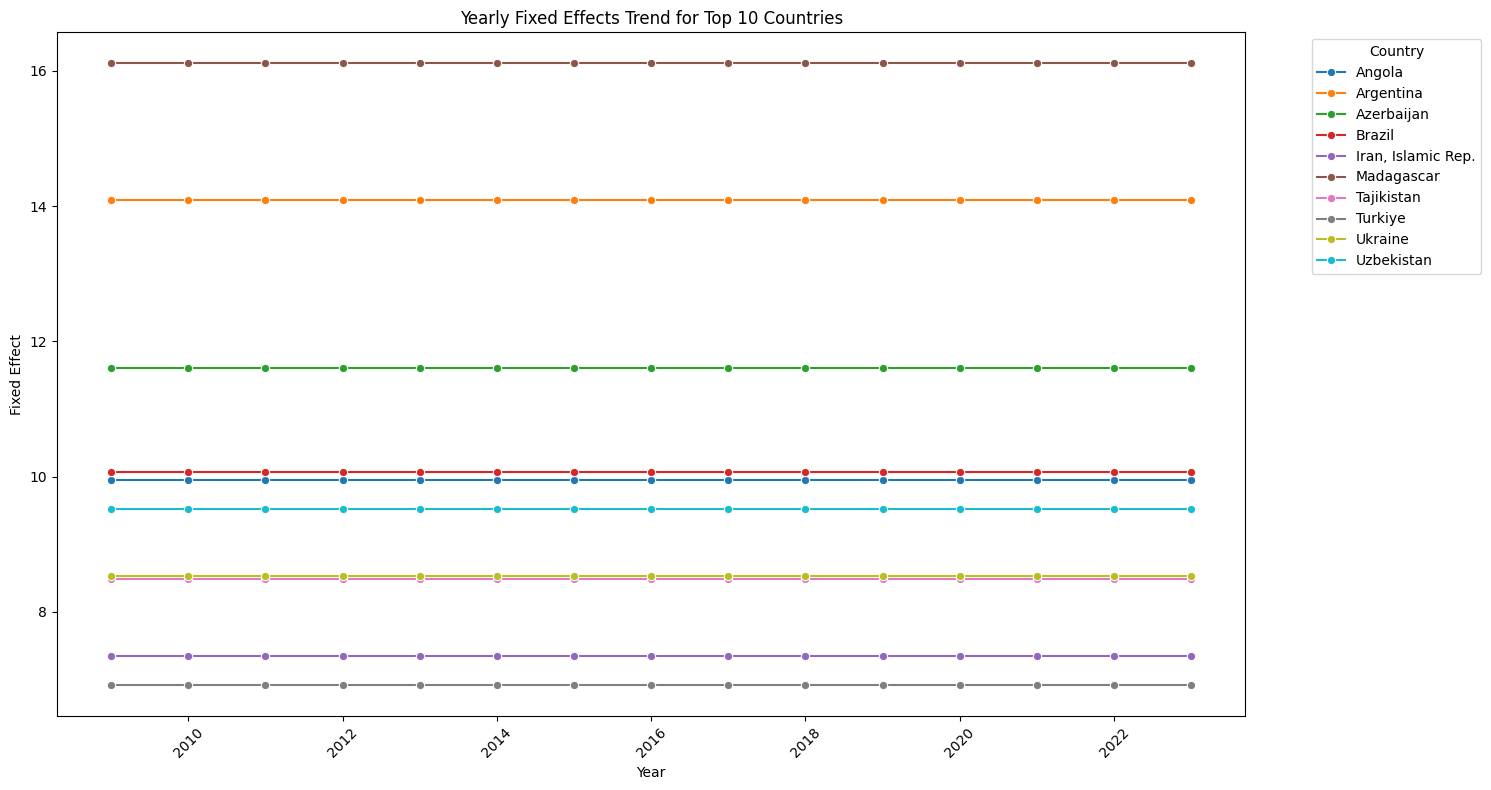

Yearly Fixed Effects Insights for Top 10 Countries (Preview):
      Country  Year  Fixed Effect
0      Angola  2009      9.956895
1      Angola  2010      9.956895
2      Angola  2011      9.956895
3      Angola  2012      9.956895
4      Angola  2013      9.956895
5      Angola  2014      9.956895
6      Angola  2015      9.956895
7      Angola  2016      9.956895
8      Angola  2017      9.956895
9      Angola  2018      9.956895
10     Angola  2019      9.956895
11     Angola  2020      9.956895
12     Angola  2021      9.956895
13     Angola  2022      9.956895
14     Angola  2023      9.956895
15  Argentina  2009     14.091698
16  Argentina  2010     14.091698
17  Argentina  2011     14.091698
18  Argentina  2012     14.091698
19  Argentina  2013     14.091698


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reshape the data to focus on yearly effects per country
yearly_country_effects = entity_effects_reset.melt(
    id_vars='Country',
    value_vars=[col for col in entity_effects_reset.columns if 'estimatedeffects' in col],
    var_name='Year',
    value_name='Fixed Effect'
)

# Step 2: Clean up the "Year" column for readability
yearly_country_effects['Year'] = yearly_country_effects['Year'].str.extract(r'(\d{4})').astype(int)

# Step 3: Sort the data for easier visualization
yearly_country_effects = yearly_country_effects.sort_values(by=['Country', 'Year'])

# Step 4: Extract the top 10 countries with positive fixed effects
top_10_countries = sorted_country_effects.head(10).index.tolist()

# Filter data for only the top 10 countries
top_10_yearly_effects = yearly_country_effects[yearly_country_effects['Country'].isin(top_10_countries)]

# Step 5: Visualize the yearly fixed effects trends for top 10 countries
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=top_10_yearly_effects,
    x='Year',
    y='Fixed Effect',
    hue='Country',
    marker='o',
    palette='tab10'
)
plt.title('Yearly Fixed Effects Trend for Top 10 Countries')
plt.xlabel('Year')
plt.ylabel('Fixed Effect')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 6: Display a summary DataFrame of yearly insights for the top 10 countries
top_10_summary = top_10_yearly_effects.groupby(['Country', 'Year'])['Fixed Effect'].mean().reset_index()

# Show a preview of the yearly insights
print("Yearly Fixed Effects Insights for Top 10 Countries (Preview):")
print(top_10_summary.head(20))  # Display the first 20 rows


Cleaned Columns:
Index(['index', 'Entity', 'estimatedeffects2009', 'estimatedeffects2010',
       'estimatedeffects2011', 'estimatedeffects2012', 'estimatedeffects2013',
       'estimatedeffects2014', 'estimatedeffects2015', 'estimatedeffects2016',
       'estimatedeffects2017', 'estimatedeffects2018', 'estimatedeffects2019',
       'estimatedeffects2020', 'estimatedeffects2021', 'estimatedeffects2022',
       'estimatedeffects2023', 'Country'],
      dtype='object')
Bottom 10 Countries with Negative Fixed Effects:
Country
United States          -12.882002
Hong Kong SAR, China   -10.612937
Japan                   -8.802653
United Kingdom          -7.987077
Belarus                 -6.733302
Lithuania               -6.565128
Montenegro              -6.551853
Netherlands             -5.545625
Lebanon                 -5.463560
Palau                   -5.259661
Name: Fixed Effect, dtype: float64


<ipython-input-76-50fd95e54450>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


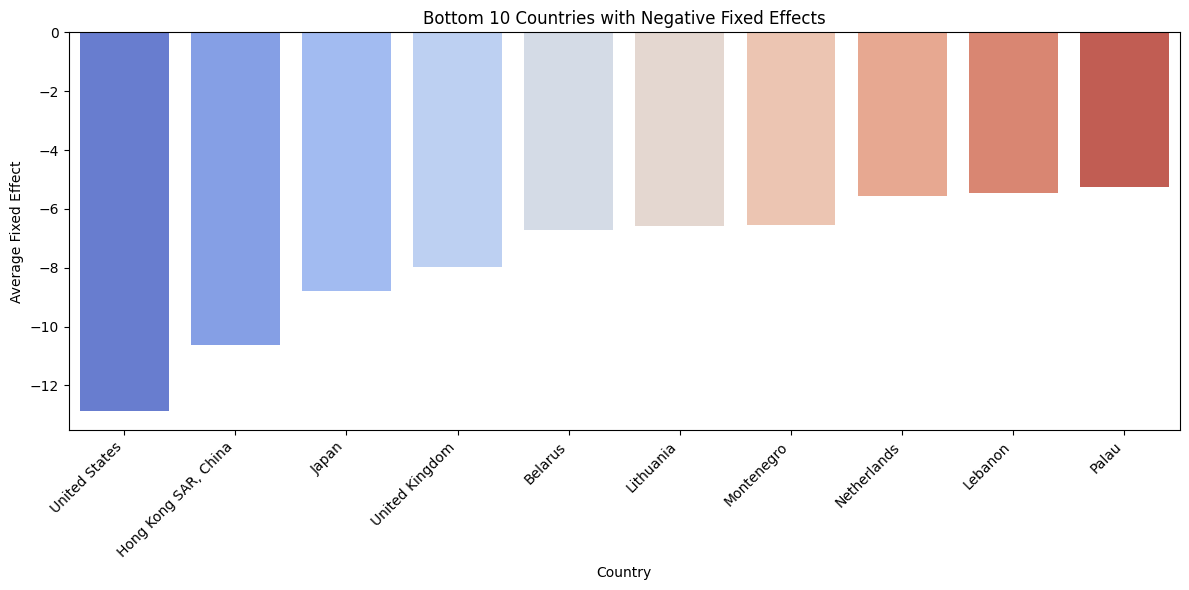

In [76]:
# Step 1: Clean and standardize column names
entity_effects_reset.columns = [
    ''.join(col.split('_')).replace(' ', '').replace('_______________', '').strip() for col in entity_effects_reset.columns
]

# Step 2: Inspect the cleaned columns
print("Cleaned Columns:")
print(entity_effects_reset.columns)

# Step 3: Rename columns explicitly if required
# Attempt to identify the country column and fix its name
for col in entity_effects_reset.columns:
    if 'Country' in col:
        entity_effects_reset.rename(columns={col: 'Country'}, inplace=True)
        break
else:
    raise KeyError("The column 'Country' could not be found even after cleaning.")

# Step 4: Identify and select estimated effects columns
effect_cols = [col for col in entity_effects_reset.columns if 'estimatedeffects' in col.lower()]
if not effect_cols:
    raise KeyError("No 'estimatedeffects' columns found after cleaning column names.")

# Step 5: Continue with analysis as previously outlined
# Create DataFrame with Country and effects
country_effects_df = entity_effects_reset[['Country'] + effect_cols]

# Step 6: Melt DataFrame for analysis
country_effects_melted = country_effects_df.melt(
    id_vars='Country',
    value_vars=effect_cols,
    var_name='Year',
    value_name='Fixed Effect'
)

# Step 7: Calculate mean fixed effect for each country
country_effects_mean = country_effects_melted.groupby('Country')['Fixed Effect'].mean()

# Step 8: Sort in ascending order for bottom 10 countries
bottom_10_countries_negative = country_effects_mean.sort_values(ascending=True).head(10)
print("Bottom 10 Countries with Negative Fixed Effects:")
print(bottom_10_countries_negative)

# Step 9: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    x=bottom_10_countries_negative.index,
    y=bottom_10_countries_negative.values,
    palette='coolwarm'
)
plt.title('Bottom 10 Countries with Negative Fixed Effects')
plt.xlabel('Country')
plt.ylabel('Average Fixed Effect')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


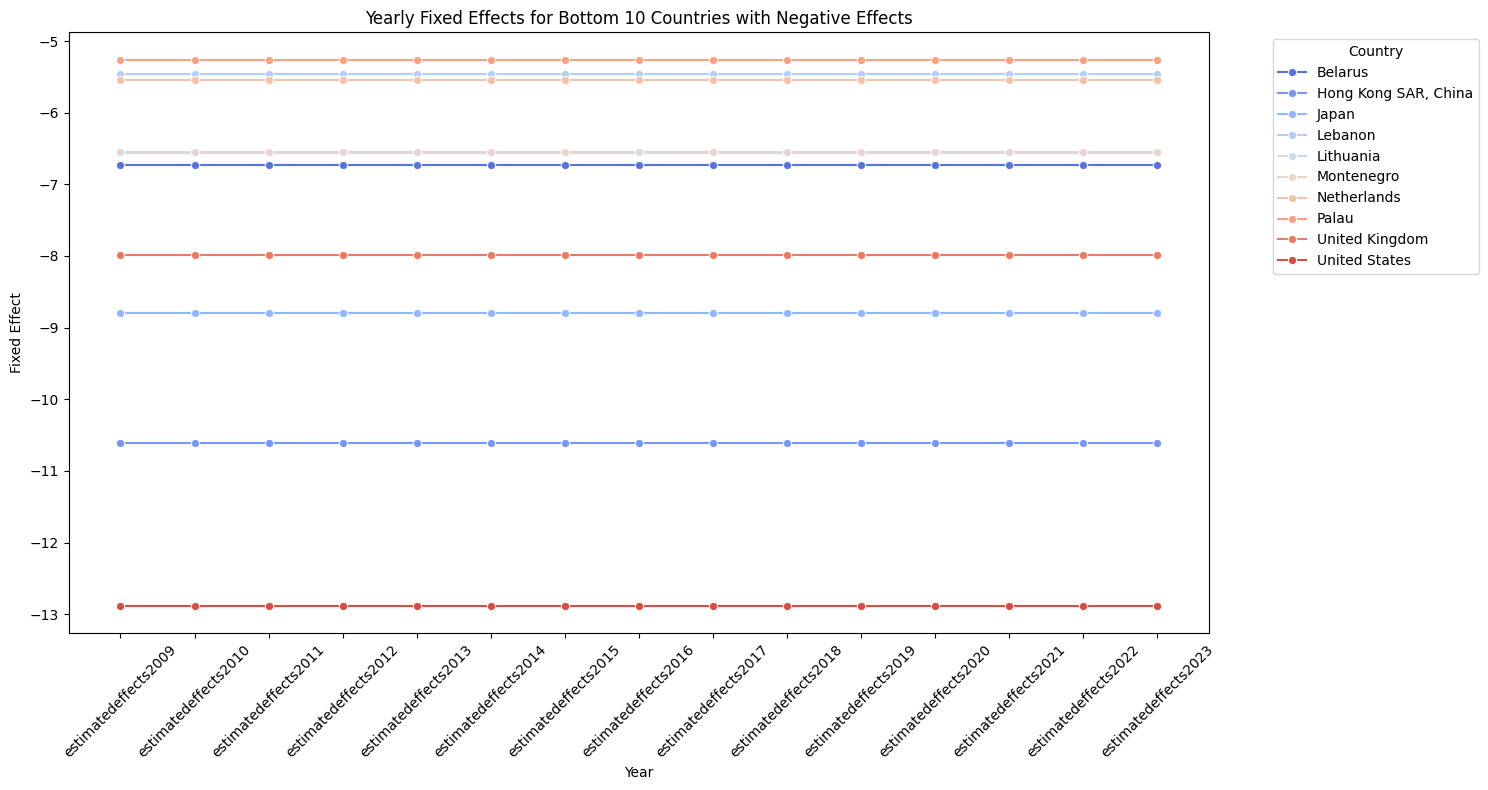

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter the data for the bottom 10 countries
bottom_10_countries = sorted_country_effects.tail(10).index
bottom_10_data = country_effects_melted[country_effects_melted['Country'].isin(bottom_10_countries)]

# Step 2: Group by Country and Year, and calculate the mean fixed effect
yearly_bottom_10 = bottom_10_data.groupby(['Country', 'Year'])['Fixed Effect'].mean().reset_index()

# Step 3: Visualization for Yearly Fixed Effects
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=yearly_bottom_10,
    x='Year',
    y='Fixed Effect',
    hue='Country',
    marker='o',
    palette='coolwarm'
)
plt.title('Yearly Fixed Effects for Bottom 10 Countries with Negative Effects')
plt.xlabel('Year')
plt.ylabel('Fixed Effect')
plt.xticks(rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


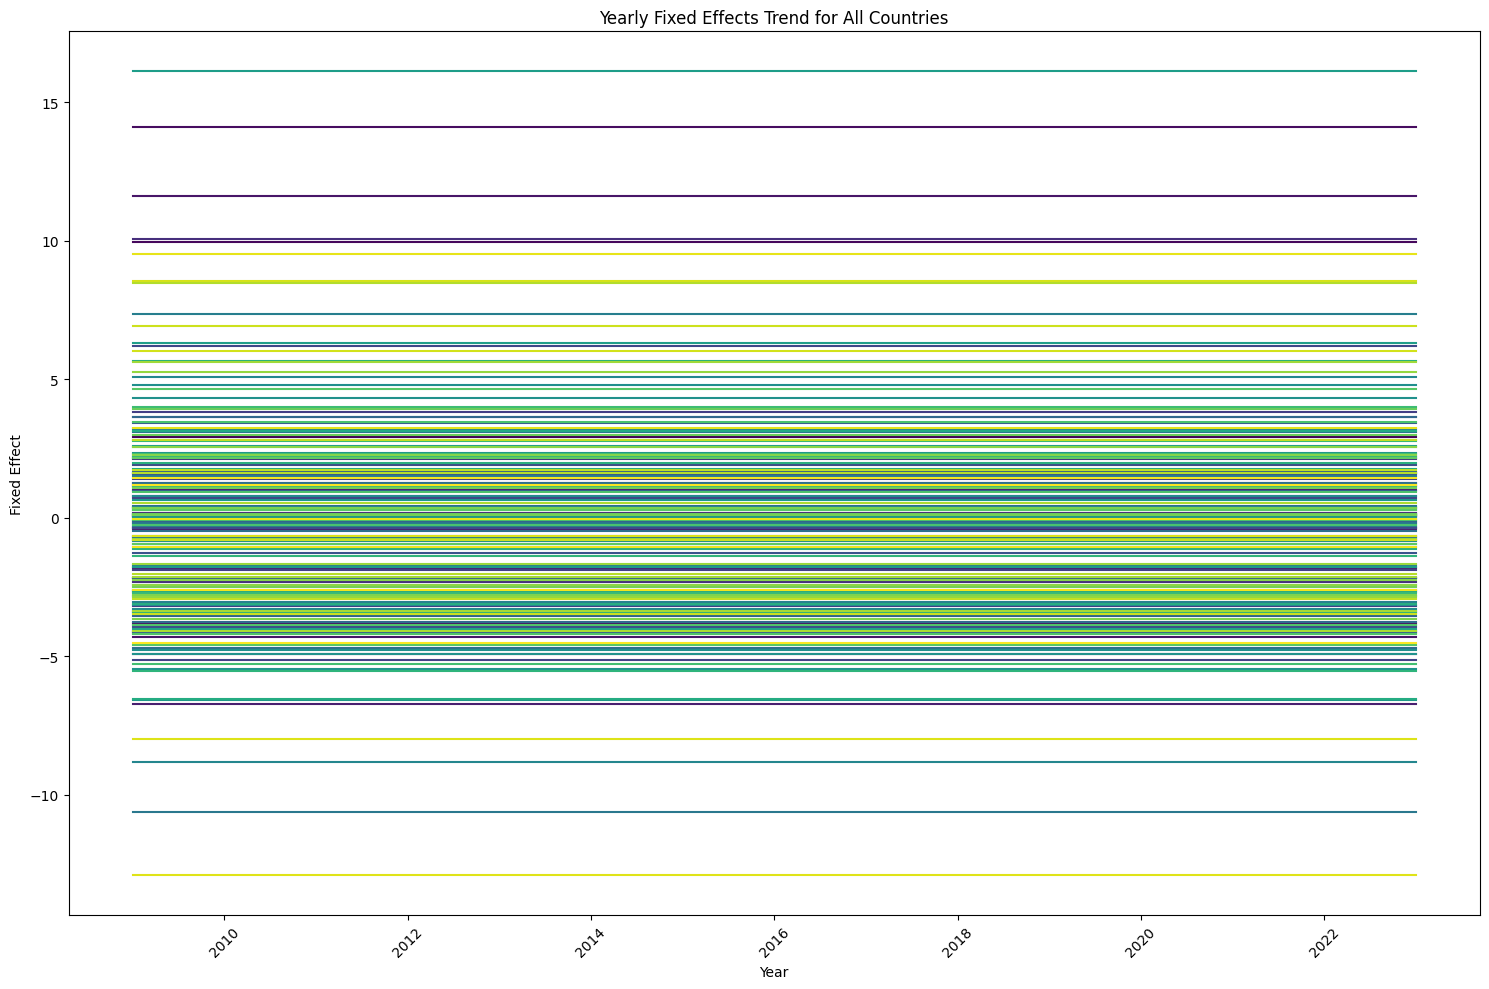

Yearly Fixed Effects Insights (Preview):
        Country  Year  Fixed Effect
0   Afghanistan  2009      2.914934
1   Afghanistan  2010      2.914934
2   Afghanistan  2011      2.914934
3   Afghanistan  2012      2.914934
4   Afghanistan  2013      2.914934
5   Afghanistan  2014      2.914934
6   Afghanistan  2015      2.914934
7   Afghanistan  2016      2.914934
8   Afghanistan  2017      2.914934
9   Afghanistan  2018      2.914934
10  Afghanistan  2019      2.914934
11  Afghanistan  2020      2.914934
12  Afghanistan  2021      2.914934
13  Afghanistan  2022      2.914934
14  Afghanistan  2023      2.914934
15      Albania  2009     -4.899314
16      Albania  2010     -4.899314
17      Albania  2011     -4.899314
18      Albania  2012     -4.899314
19      Albania  2013     -4.899314


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reshape the data to focus on yearly effects per country
yearly_country_effects = entity_effects_reset.melt(
    id_vars='Country',
    value_vars=[col for col in entity_effects_reset.columns if 'estimatedeffects' in col],
    var_name='Year',
    value_name='Fixed Effect'
)

# Step 2: Clean up the "Year" column for readability
yearly_country_effects['Year'] = yearly_country_effects['Year'].str.extract(r'(\d{4})').astype(int)

# Step 3: Sort the data for easier visualization
yearly_country_effects = yearly_country_effects.sort_values(by=['Country', 'Year'])

# Step 4: Visualize the yearly fixed effects trends for all countries
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=yearly_country_effects,
    x='Year',
    y='Fixed Effect',
    hue='Country',
    legend=False,  # To avoid a crowded legend
    palette='viridis'
)
plt.title('Yearly Fixed Effects Trend for All Countries')
plt.xlabel('Year')
plt.ylabel('Fixed Effect')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: Display a summary DataFrame of yearly insights for all countries
summary = yearly_country_effects.groupby(['Country', 'Year'])['Fixed Effect'].mean().reset_index()

# Show a preview of the yearly insights
print("Yearly Fixed Effects Insights (Preview):")
print(summary.head(20))  # Display the first 20 rows
